# Homework 6

### CSCI 611, Spring 2024

Jesse Coulson

## Problem Statement
We are trying to classify mushrooms into edible or poisonous based on categorical features.

Subtasks:
 - Transform categorical attributes to numeric attributes
 - build a decision tree classifier and a multi tree classifier
 - Create visualizations of results from classifiers with metrics
 - generate graphical form of the tree diagram from best decision tree
 - analyze the experience of making a decision tree clasifier from a categorical dataset

In [13]:
#libraries needed for this ipynb
import seaborn as sns
import pandas as pd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

## Reading in Data and Checking Format
 - Reading in data with read_csv from csv downloaded from assignment page
 - Printing out head of dataframe to see sample of vars
 - Examine info on data types of dataframe

In [14]:
#read in df
df= pd.read_csv("mushroom.csv")

#print data to see data and format
print(df.head(), "\n")

#verify all types are categorical
df.info()


  cap-shape cap-surface          cap-color bruises?    odor gill-attachment  \
0    convex               smooth     white  bruises  almond            free   
1    convex               smooth     white  bruises  almond            free   
2    convex               smooth     white  bruises  almond            free   
3    convex               smooth     white  bruises  almond            free   
4    convex               smooth     white  bruises  almond            free   

  gill-spacing gill-size gill-color stalk-shape  ... stalk-color-above-ring  \
0      crowded    narrow      white    tapering  ...                  white   
1      crowded    narrow      white    tapering  ...                  white   
2      crowded    narrow       pink    tapering  ...                  white   
3      crowded    narrow       pink    tapering  ...                  white   
4      crowded    narrow      brown    tapering  ...                  white   

  stalk-surface-color-ring veil-type veil-color ri

## Categorical Variable transformation
 - using ColumnTransformer to turn all features numeric
 - will use one hot encoding for some and ordinal for others where there is hierarchy

In [15]:
#the column namesahve whitespace need to strip out
df.columns = df.columns.str.strip()

#veil type only has one type so doesnt make sense to use, so will remove
df['veil-type'].unique()
df = df.drop(columns=['veil-type'])

bin_var = {'edibleness': {'edible':1, 'poisonous':0}} 
df = df.replace(bin_var)

bin_var = {'bruises?': {'no':0, 'bruises':1}} 
df = df.replace(bin_var)

ordinal_vars = ['gill-size', 'ring-number']
#binary_vars = ['bruises?', 'edibleness']
onehot_vars = ['cap-shape',
'cap-surface',         
'cap-color',
'odor',
'gill-attachment',
'gill-spacing',
'gill-color',
'stalk-shape',
'stalk-root',
'stalk-surface-above-ring',
'stalk-surface-below-ring',
'stalk-color-above-ring',
'stalk-surface-color-ring',
#'veil-type',
'veil-color',
'ring-type',
'spore-print-color',  
'population',
'habitat']

C:\Users\jesse\AppData\Local\Temp\ipykernel_2672\4165020321.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(bin_var)
C:\Users\jesse\AppData\Local\Temp\ipykernel_2672\4165020321.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(bin_var)


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

column_transformer = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), onehot_vars),
    ('ordinal', OrdinalEncoder(), ordinal_vars),
    ],
    remainder='passthrough' #for the already encoded binary vars
    )

In [17]:

trans_data = column_transformer.fit_transform(df)

# Get one-hot encoded feature names
onehot_feature_names = column_transformer.named_transformers_['onehot'].get_feature_names_out()

# Combine all feature names
all_feature_names = np.concatenate([onehot_feature_names, ordinal_vars, ['bruises?','edibleness']]) #putting binary encoded vars in correct order

trans_df = pd.DataFrame(trans_data.toarray(), columns=all_feature_names)
trans_df.head()

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,...,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,gill-size,ring-number,bruises?,edibleness
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [18]:
#seeing correlation of all vars
corr_matrix = trans_df.corr(numeric_only= True)
corr_matrix["edibleness"].sort_values(ascending=False)

edibleness                         1.000000
odor_none                          0.793034
ring-type_pendant                  0.494286
stalk-surface-above-ring_smooth    0.466675
bruises?                           0.462454
                                     ...   
gill-size                         -0.540032
gill-color_buff                   -0.543331
stalk-surface-below-ring_silky    -0.579364
stalk-surface-above-ring_silky    -0.595875
odor_foul                         -0.628086
Name: edibleness, Length: 113, dtype: float64

## Making visualizations of promising variables
 - Choosing the top 4 positively correlated vars and the top 4 negatively correlated vars
 - vars are odor_none, ring-type_pendant, stalk-surface-above-ring_smooth, bruises?, odor_foul, stalk-surface-above-ring_silky, stalk-surface-below-ring_silky, gill-color_buff
 - Most of these variables are all binary yes or no for the given category after the one hot. The only non binary feature is gill size which was ordinal encoded

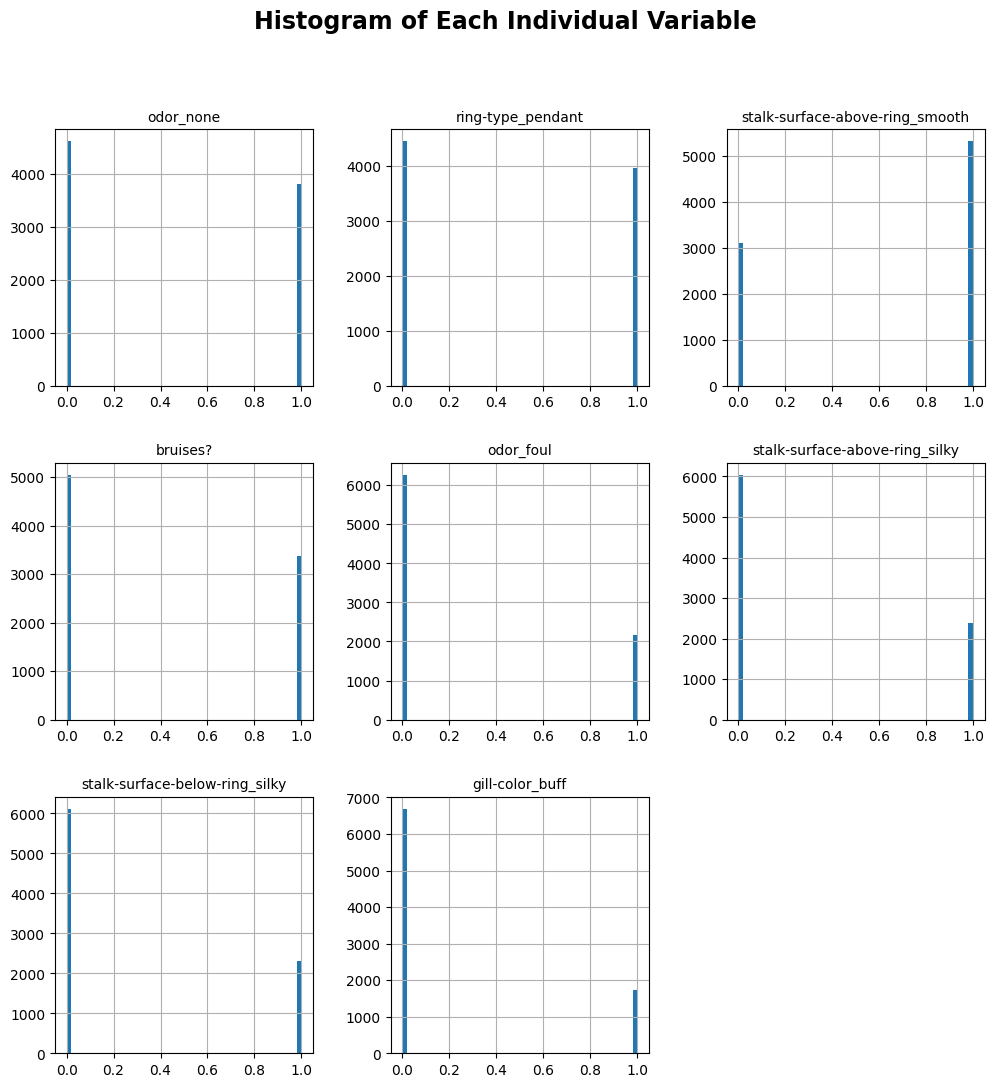

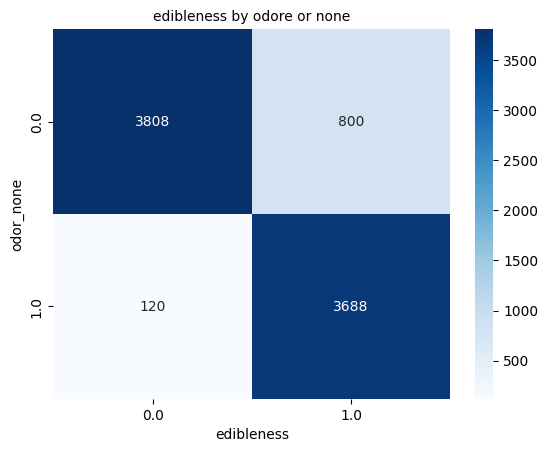

<Figure size 640x480 with 0 Axes>

In [22]:
#plots of histogram
cols = ['odor_none', 'ring-type_pendant', 'stalk-surface-above-ring_smooth', 'bruises?', 'odor_foul', 'stalk-surface-above-ring_silky', 'stalk-surface-below-ring_silky', 'gill-color_buff']

#histograms of the variables
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
#small plots side by side
trans_df[cols].hist(bins=50, figsize=(12, 12))
#title for histograms
plt.suptitle('Histogram of Each Individual Variable', fontsize=17, fontweight = "bold",verticalalignment='top', horizontalalignment='center')
plt.show()





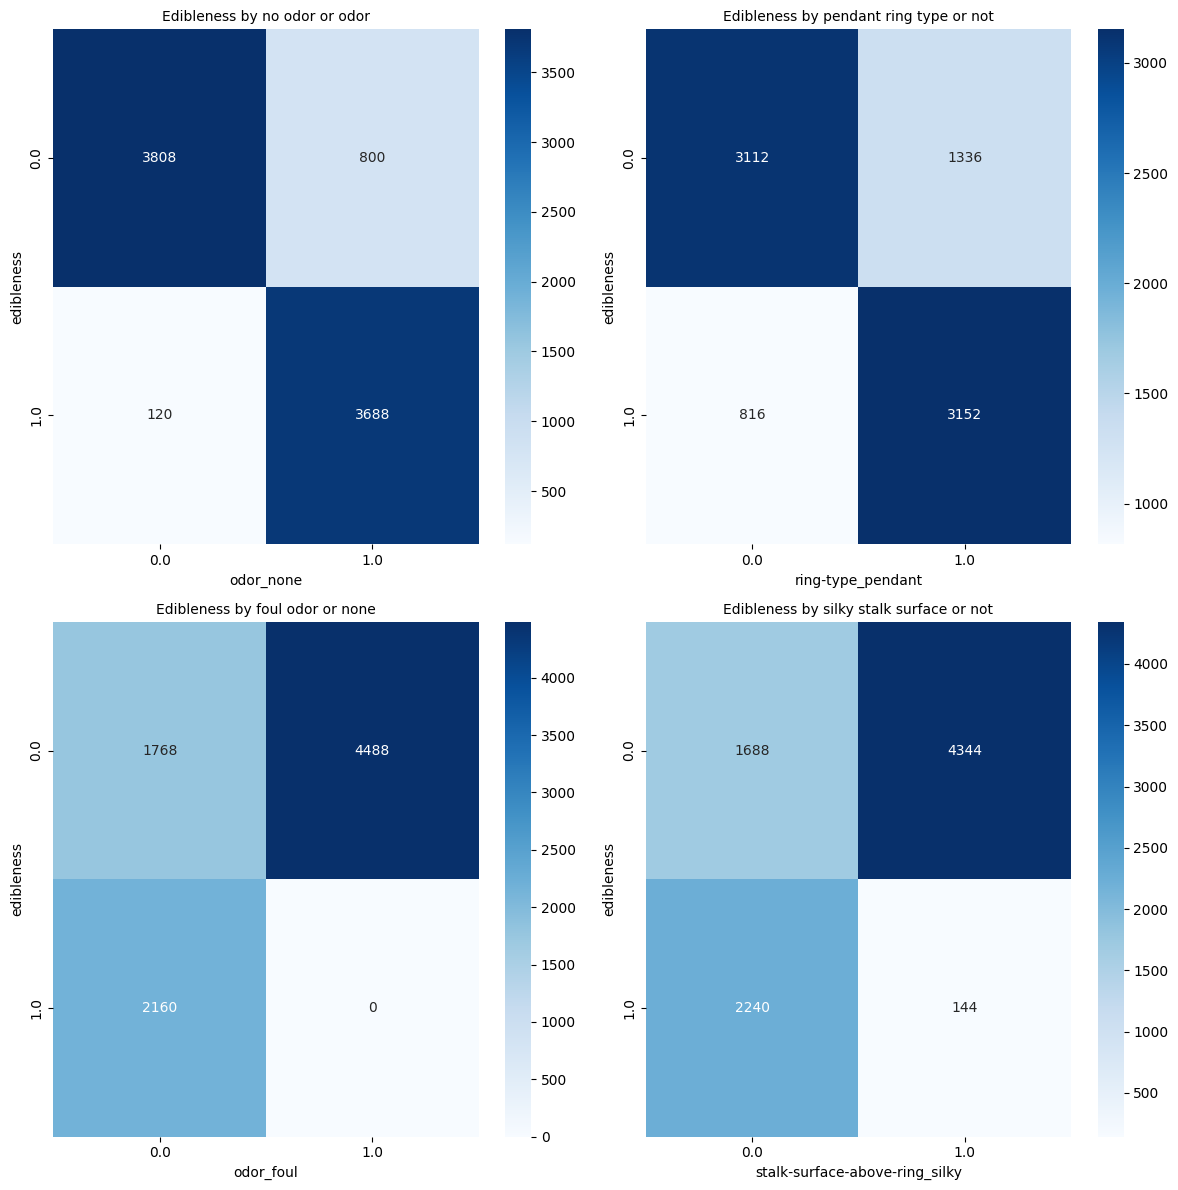

In [31]:
col_freq_1 = pd.crosstab(trans_df['odor_none'], trans_df['edibleness'])
col_freq_2 = pd.crosstab(trans_df['ring-type_pendant'], trans_df['edibleness'])
col_freq_3 = pd.crosstab(trans_df['odor_foul'], trans_df['edibleness'])
col_freq_4 = pd.crosstab(trans_df['stalk-surface-above-ring_silky'], trans_df['edibleness'])

# Set up the matplotlib figure with four subplots (2x2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))  # Adjusted figsize for better visibility

# Heatmap for the first crosstab
sns.heatmap(col_freq_1, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Edibleness by no odor or odor')
axes[0, 0].set_xlabel('odor_none')
axes[0, 0].set_ylabel('edibleness')

# Heatmap for the second crosstab
sns.heatmap(col_freq_2, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Edibleness by pendant ring type or not')
axes[0, 1].set_xlabel('ring-type_pendant')
axes[0, 1].set_ylabel('edibleness')

# Heatmap for the third crosstab
sns.heatmap(col_freq_3, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Edibleness by foul odor or none')
axes[1, 0].set_xlabel('odor_foul')
axes[1, 0].set_ylabel('edibleness')

# Heatmap for the fourth crosstab
sns.heatmap(col_freq_4, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Edibleness by silky stalk surface or not')
axes[1, 1].set_xlabel('stalk-surface-above-ring_silky')
axes[1, 1].set_ylabel('edibleness')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [33]:

X = trans_df[['odor_none', 'ring-type_pendant', 'stalk-surface-above-ring_smooth', 'bruises?', 'odor_foul', 'stalk-surface-above-ring_silky', 'stalk-surface-below-ring_silky', 'gill-color_buff']] 
y = trans_df['edibleness'] #get target feature

#splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(
   X, y, random_state=42)


Hypereparams of best decision tree model: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2}
Accuracy score of best decision tree model: 0.9589658361283538


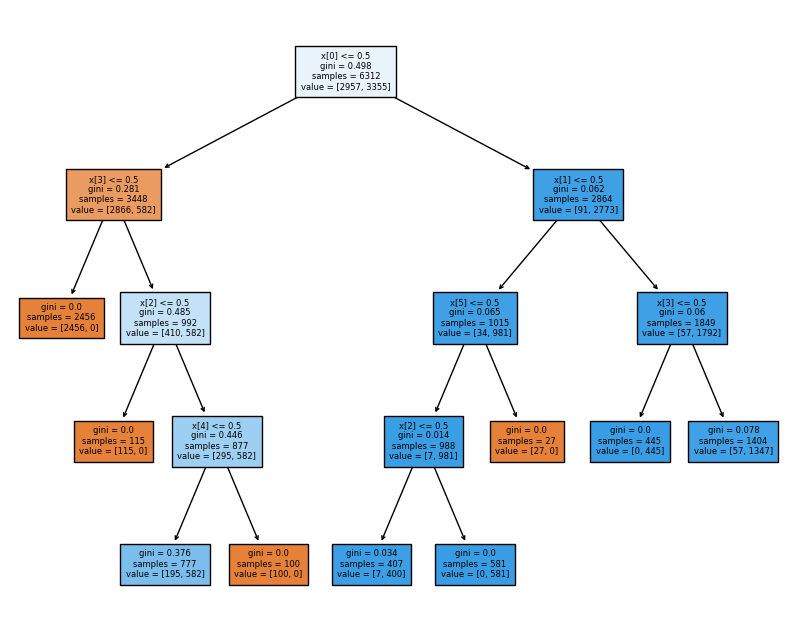

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV



decision_tree_grid= GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_split': [2,5,10],
                         'max_features':['sqrt', 'log2']
                         }, cv=5)

decision_tree_grid.fit(X_train, y_train)

#printing the optimal hyperparametrs and accuracy of the model
print("Hypereparams of best decision tree model:", decision_tree_grid.best_params_)
print("Accuracy score of best decision tree model:", decision_tree_grid.best_score_)


plt.figure(figsize=(10, 8))  # Set the figure size (optional)
plot_tree(decision_tree_grid.best_estimator_, filled=True, fontsize=6) #need filled=True for color
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier
random_forest_grid= GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_split': [2,5,10],
                         'max_features':['sqrt', 'log2'], 'bootstrap': [True, False]
                         }, cv=5)

random_forest_grid.fit(X_train, y_train)

#printing the optimal hyperparametrs and accuracy of the model
print("Hypereparams of best random forest model:", random_forest_grid.best_params_)
print("Accuracy score of best random forest model:", random_forest_grid.best_score_)



Hypereparams of best random forest model: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Accuracy score of best random forest model: 0.9589658361283538


## Final test metrics

Accuracy on test set:  0.9596007604562737
Precision:  0.9651067323481117
Recall:  0.9562306900102986
F1 score:  0.9590362102584928


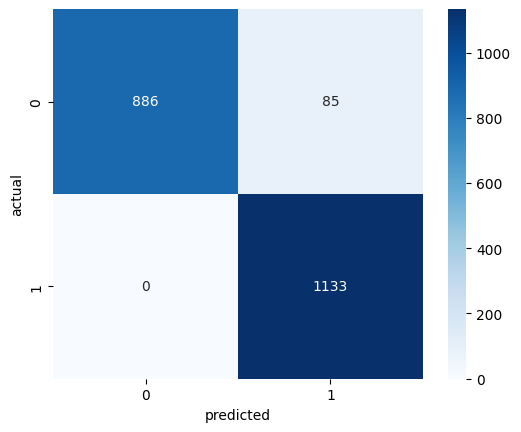

<Figure size 640x480 with 0 Axes>

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_pred = decision_tree_grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)

#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred, average='macro') 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)


#creating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
plt.clf()

Accuracy on test set:  0.9596007604562737
Precision:  0.9651067323481117
Recall:  0.9562306900102986
F1 score:  0.9590362102584928


Text(77.92222222222227, 0.5, 'actual')

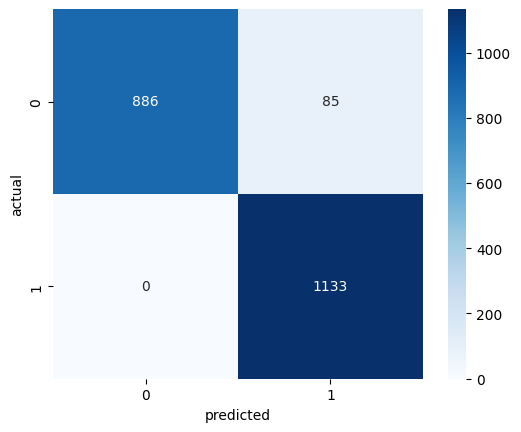

In [70]:
y_pred = random_forest_grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)

#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred, average='macro') 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1)


#creating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual')